In [2]:
import sys
# sys.path.append('/home/ubuntu/Workspace/utils/FishFeeding')
import cv2
from utils.video_preprocess import resize_video
import numpy as np
import copy
import mmcv
import time

In [2]:
device = 'cuda:0'

# 1 - 预处理

需要在视觉上基本克服常规水面波动的影响，例如吹风。

### 1.1 - 预处理1：均值漂移

In [ ]:
cap = cv2.VideoCapture('/Users/liuziyi/Desktop/220731_170753__220731_173752_clip_2.mp4')

while(True):
    check, img = cap.read()
    if check:
        cv2.imshow("raw", img)

        img_float = np.float32(img)  # Convert image from unsigned 8 bit to 32 bit float
        criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
        meanshift = cv2.pyrMeanShiftFiltering(img, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))
        # Apply meanshift algorithm on to image
        cv2.imshow("Output of meanshift", meanshift)
        
        key = cv2.waitKey(30)
        if key >= 0:
            cv2.waitKey(0)
            break
    else:
        break

# Close the window / Release webcam
cap.release()
  
# De-allocate any associated memory usage 
cv2.destroyAllWindows()


# 2 - 光流估计

In [14]:
from itertools import count
from mmflow.apis import inference_model, init_model

try:
    import imageio
except ImportError:
    imageio = None

# build the model from a config file and a checkpoint file
config_file = '/home/ubuntu/Workspace/mmflow/configs/pwcnet/pwcnet_ft_4x1_300k_sintel_final_384x768.py'  # '/home/ubuntu/Workspace/mmflow/configs/gma/gma_plus-p_8x2_120k_mixed_368x768.py'
config = mmcv.Config.fromfile(config_file)
if device != 'cuda:0':
    # modify as BN
    pass
checkpoint_file = './pwcnet_ft_4x1_300k_sintel_final_384x768.pth'  # './gma_plus-p_8x2_120k_mixed_368x768.pth'
model = init_model(config, checkpoint_file, device=device)

# load video
video = './220731_170753__220731_173752_clip_2.mp4'
cap = cv2.VideoCapture(video)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

r = []
count = 0
criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
flag1, img1 = cap.read()
meanshift1 = cv2.pyrMeanShiftFiltering(img1, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))
while (cap.isOpened()):
    # Get frames
    count += 1
    # if count > 10000:
    #     break

    ret = cap.grab()
    if not ret:
        break
    
    if count % 5 == 1:
        ret, img2 = cap.retrieve()
        if img2 is None:
            break
        
        time_start1 = time.time()
        meanshift2 = cv2.pyrMeanShiftFiltering(img2, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))
        result = inference_model(model, meanshift1[100:700, :, :], meanshift2[100:700, :, :])
        # result = inference_model(model, meanshift1, meanshift2)
        r.append(np.sum(np.sqrt(np.power(result[:, :, 0], 2) + np.power(result[:, :, 1], 2))))        
        meanshift1 = copy.deepcopy(meanshift2)
        
        time_end1 = time.time()
    print('loop duration: ', time_end1 - time_start1)

cap.release()

load checkpoint from local path: ./pwcnet_ft_4x1_300k_sintel_final_384x768.pth
loop duration:  0.20506525039672852
loop duration:  0.20506525039672852
loop duration:  0.20506525039672852
loop duration:  0.20506525039672852
loop duration:  0.20506525039672852
loop duration:  0.20384669303894043
loop duration:  0.20384669303894043
loop duration:  0.20384669303894043
loop duration:  0.20384669303894043
loop duration:  0.20384669303894043
loop duration:  0.20327544212341309
loop duration:  0.20327544212341309
loop duration:  0.20327544212341309
loop duration:  0.20327544212341309
loop duration:  0.20327544212341309
loop duration:  0.20126843452453613
loop duration:  0.20126843452453613
loop duration:  0.20126843452453613
loop duration:  0.20126843452453613
loop duration:  0.20126843452453613
loop duration:  0.20312237739562988
loop duration:  0.20312237739562988
loop duration:  0.20312237739562988
loop duration:  0.20312237739562988
loop duration:  0.20312237739562988
loop duration:  0.204

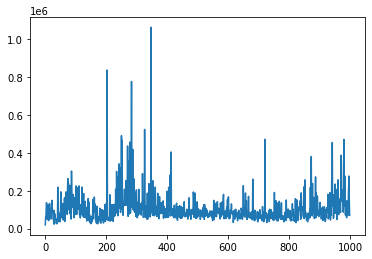

In [4]:
import matplotlib.pyplot as plt

# gma_plus-p_8x2_120k_mixed_368x768
plt.plot(r)
plt.show()

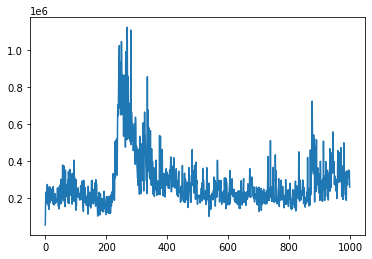

In [7]:
import matplotlib.pyplot as plt

# pwcnet_ft_4x1_300k_sintel_final_384x768
plt.plot(r)
plt.show()

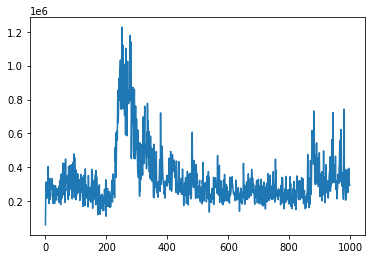

In [9]:
import matplotlib.pyplot as plt

# pwcnet_ft_4x1_300k_sintel_final_384x768 + meanshift1[100:700, :, :]
plt.plot(r)
plt.show()

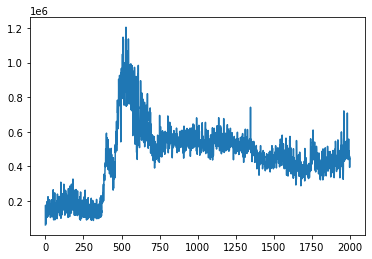

In [11]:
import matplotlib.pyplot as plt

# pwcnet_ft_4x1_300k_sintel_final_384x768 + meanshift1[100:700, :, :] + count % 5 = 1
plt.plot(r)
plt.show()

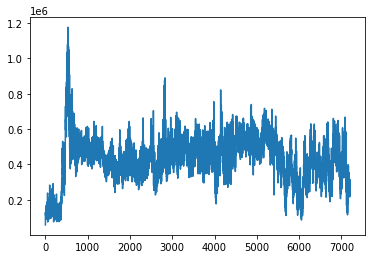

In [15]:
import matplotlib.pyplot as plt

# pwcnet_ft_4x1_300k_sintel_final_384x768 + meanshift + count % 5 = 1 + 24min
plt.plot(r)
plt.show()

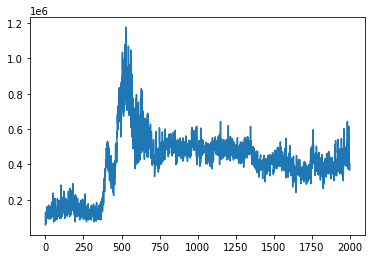

In [13]:
import matplotlib.pyplot as plt

# pwcnet_ft_4x1_300k_sintel_final_384x768 + count % 5 = 1
plt.plot(r)
plt.show()

In [ ]:
from mmflow.apis import inference_model, init_model

try:
    import imageio
except ImportError:
    imageio = None

# build the model from a config file and a checkpoint file
config_file = '/home/ubuntu/Workspace/mmflow/configs/gma/gma_plus-p_8x2_120k_mixed_368x768.py'
config = mmcv.Config.fromfile(config_file)
if device != 'cuda:0':
    # modify as BN
    pass
checkpoint_file = './gma_plus-p_8x2_120k_mixed_368x768.pth'
model = init_model(config, checkpoint_file, device=device)

# load video
video = './220731_170753__220731_173752_clip_2.mp4'
cap = cv2.VideoCapture(video)
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

r = []
while (cap.isOpened()):
    # Get frames
    flag1, img1 = cap.read()
    flag2, img2 = cap.read()

    if flag1 and flag2:
        # img1 = np.float32(img1)  # Convert image from unsigned 8 bit to 32 bit float
        criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
        img1 = cv2.pyrMeanShiftFiltering(img1, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))

        # img2 = np.float32(img2)  # Convert image from unsigned 8 bit to 32 bit float
        criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
        img2 = cv2.pyrMeanShiftFiltering(img2, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))

        result = inference_model(model, img1, img2)
        r.append(np.sum(np.sqrt(np.power(result[:, :, 0], 2) + np.power(result[:, :, 1], 2))))
    else:
        break

cap.release()

In [3]:
config_file = '/home/ubuntu/Workspace/mmflow/configs/gma/gma_plus-p_8x2_120k_mixed_368x768.py'
config = mmcv.Config.fromfile(config_file)
config

Config (path: /home/ubuntu/Workspace/mmflow/configs/gma/gma_plus-p_8x2_120k_mixed_368x768.py): {'model': {'type': 'RAFT', 'num_levels': 4, 'radius': 4, 'cxt_channels': 128, 'h_channels': 128, 'encoder': {'type': 'RAFTEncoder', 'in_channels': 3, 'out_channels': 256, 'net_type': 'Basic', 'norm_cfg': {'type': 'IN'}, 'init_cfg': [{'type': 'Kaiming', 'layer': ['Conv2d'], 'mode': 'fan_out', 'nonlinearity': 'relu'}, {'type': 'Constant', 'layer': ['InstanceNorm2d'], 'val': 1, 'bias': 0}]}, 'cxt_encoder': {'type': 'RAFTEncoder', 'in_channels': 3, 'out_channels': 256, 'net_type': 'Basic', 'norm_cfg': {'type': 'SyncBN'}, 'init_cfg': [{'type': 'Kaiming', 'layer': ['Conv2d'], 'mode': 'fan_out', 'nonlinearity': 'relu'}, {'type': 'Constant', 'layer': ['SyncBatchNorm2d'], 'val': 1, 'bias': 0}]}, 'decoder': {'type': 'GMADecoder', 'net_type': 'Basic', 'num_levels': 4, 'radius': 4, 'iters': 12, 'corr_op_cfg': {'type': 'CorrLookup', 'align_corners': True}, 'gru_type': 'SeqConv', 'heads': 1, 'motion_channe

In [ ]:
import cv2
from cvzone.SelfiSegmentationModule import SelfiSegmentation
import numpy as np

cap = cv2.VideoCapture('./220731_170753__220731_173752_clip_2.mp4')

while(True):
    check, img = cap.read()
    if check:
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        # lab = cv2.cvtColor(img, cv2.COLOR_BGR2 )
        us = yuv[:, :, 1] - hsv[:, :, 1]
        
        # cv2.imshow("u - s", us)
        cv2.imshow("raw", img)
        # cv2.imshow("hsv", hsv)
        # cv2.imshow("yuv", yuv)

        img_float = np.float32(img)  # Convert image from unsigned 8 bit to 32 bit float
        criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
        # Defining the criteria ( type, max_iter, epsilon )
        # cv2.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
        # cv2.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
        # cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.
        # max_iter - An integer specifying maximum number of iterations.In this case it is 10
        # epsilon - Required accuracy.In this case it is 1
        # k = 50  # Number of clusters
        # ret, label, centers = cv2.kmeans(img_float, k, None, criteria, 50, cv2.KMEANS_RANDOM_CENTERS)
        # # apply kmeans algorithm with random centers approach
        # center = np.uint8(centers)
        # # Convert the image from float to unsigned integer
        # res = center[label.flatten()]
        # # This will flatten the label
        # res2 = res.reshape(img.shape)
        # # Reshape the image
        # cv2.imshow("K Means", res2)  # Display image
        # cv2.imwrite("1.jpg", res2)  # Write image onto disk
        meanshift = cv2.pyrMeanShiftFiltering(img, sp=8, sr=16, maxLevel=1, termcrit=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 5, 1))
        # Apply meanshift algorithm on to image
        cv2.imshow("Output of meanshift", meanshift)
        # Display image
        # cv2.imwrite("2.jpg", meanshift)
        # Write image onto disk
        # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # # Convert image from RGB to GRAY
        # ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # # apply thresholding to convert the image to binary
        # fg = cv2.erode(thresh, None, iterations=1)
        # # erode the image
        # bgt = cv2.dilate(thresh, None, iterations=1)
        # # Dilate the image
        # ret, bg = cv2.threshold(bgt, 1, 128, 1)
        # # Apply thresholding
        # marker = cv2.add(fg, bg)
        # # Add foreground and background
        # canny = cv2.Canny(marker, 110, 150)
        # # Apply canny edge detector
        # contours, hierarchy = cv2.findContours(canny, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # # Finding the contors in the image using chain approximation
        # marker32 = np.int32(marker)
        # # converting the marker to float 32 bit
        # cv2.watershed(img,marker32)
        # # Apply watershed algorithm
        # m = cv2.convertScaleAbs(marker32)
        # ret, thresh = cv2.threshold(m, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        # # Apply thresholding on the image to convert to binary image
        # thresh_inv = cv2.bitwise_not(thresh)
        # # Invert the thresh
        # res = cv2.bitwise_and(img, img, mask=thresh)
        # # Bitwise and with the image mask thresh
        # res3 = cv2.bitwise_and(img, img, mask=thresh_inv)
        # # Bitwise and the image with mask as threshold invert
        # res4 = cv2.addWeighted(res, 1, res3, 1, 0)
        # # Take the weighted average
        # final = cv2.drawContours(res4, contours, -1, (0, 255, 0), 1)
        # # Draw the contours on the image with green color and pixel width is 1
        # cv2.imshow("Watershed", final)  # Display the image
        # # cv2.imwrite("3.jpg", final)  # Write the image

        key = cv2.waitKey(30)
        if key >= 0:
            cv2.waitKey(0)
            break
    else:
        break

# Close the window / Release webcam
cap.release()
  
# De-allocate any associated memory usage 
cv2.destroyAllWindows()

In [ ]:
cv2.imshow("raw1", img)

In [ ]:
from argparse import ArgumentParser
from typing import Sequence

import cv2
import numpy as np
from numpy import ndarray

from mmflow.apis import inference_model, init_model
from mmflow.datasets import visualize_flow

try:
    import imageio
except ImportError:
    imageio = None

# build the model from a config file and a checkpoint file
model = init_model('/home/ubuntu/Workspace/mmflow/configs/pwcnet/pwcnet_ft_4x1_300k_sintel_final_384x768.py', '/home/ubuntu/Workspace/mmflow/demo/pwcnet_ft_4x1_300k_sintel_final_384x768.pth', device='cuda:0')
# load video
cap = cv2.VideoCapture('/home/ubuntu/Workspace/mmflow/demo/220731_170753__220731_173752_clip.mp4')
# assert cap.isOpened(), f'Failed to load video file {args.video}'
# get video info
size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

i = 0
r = []
while (cap.isOpened()):
    # Get frames
    flag1, img1 = cap.read()
    flag2, img2 = cap.read()

    if not flag2:
        break
    
    # i += 1
    # if i > 10:
    #     cap.release()
    #     break
    
    result = inference_model(model, img1[100:700, :, :], img2[100:700, :, :])
    r.append(np.sum(np.sqrt(np.power(result[:, :, 0], 2) + np.power(result[:, :, 1], 2))))
    # np.sqrt(np.power(result[:, :, 0], 2) + np.power(result[:, :, 1], 2))
    # print('result.shape = ', result[::0].shape)
    # flow_map = visualize_flow(result, None)
    # flow_map = cv2.cvtColor(flow_map, cv2.COLOR_RGB2BGR)
    # frame = flow_map

    # imgs.append(img)
cap.release()

In [ ]:
import sys
sys.path.append('/Users/liuziyi/Workspace/mmsegmentation')
from mmseg.apis import inference_segmentor, init_segmentor
import mmcv

config_file = '/Users/liuziyi/Workspace/mmsegmentation/configs/pspnet/pspnet_r101b-d8_512x1024_80k_cityscapes.py'
# config_file = '/Users/liuziyi/Workspace/FishFeeding/123.py'
checkpoint_file = '/Users/liuziyi/Workspace/FishFeeding/pspnet_r101b-d8_512x1024_80k_cityscapes_20201226_170012-3a4d38ab.pth'

# build the model from a config file and a checkpoint file
config = mmcv.Config.fromfile(config_file)
config["norm_cfg"]["type"] = "BN"
config["model"]["backbone"]["norm_cfg"]["type"] = "BN"
config["model"]["decode_head"]["norm_cfg"]["type"] = "BN"
config["model"]["auxiliary_head"]["norm_cfg"]["type"] = "BN"
# config["model"]["auxiliary_head"]["norm_cfg"]["type"] = "BN"
# config["model"]["auxiliary_head"]["norm_cfg"]["type"] = "BN"

# model = init_segmentor(config, checkpoint_file, device='cpu')

# # # # test a single image and show the results
# # # img = 'test.jpg'  # or img = mmcv.imread(img), which will only load it once
# # # result = inference_segmentor(model, img)
# # # # visualize the results in a new window
# # # model.show_result(img, result, show=True)
# # # # or save the visualization results to image files
# # # # you can change the opacity of the painted segmentation map in (0, 1].
# # # model.show_result(img, result, out_file='result.jpg', opacity=0.5)

# # # test a video and show the results
# # # video = mmcv.VideoReader('/home/ubuntu/Workspace/mmflow/demo/220731_170753__220731_173752_clip.mp4')
# # # for frame in video:
# # #    result = inference_segmentor(model, frame)
# # #    model.show_result(frame, result, wait_time=1)

# # # test a video and show the results
model = init_segmentor(config, checkpoint_file, device='cpu')
video = mmcv.VideoReader('/Users/liuziyi/Desktop/220731_170753__220731_173752_clip_2.mp4')

In [ ]:
i = 0
for frame in video:
   i += 1
   if i == 20:
      result = inference_segmentor(model, frame)
      model.show_result(frame, result, out_file='/Users/liuziyi/Desktop/result2.jpg', opacity=0.5)
      break

In [ ]:
config = mmcv.Config.fromfile(config_file)
config